(640, 480)


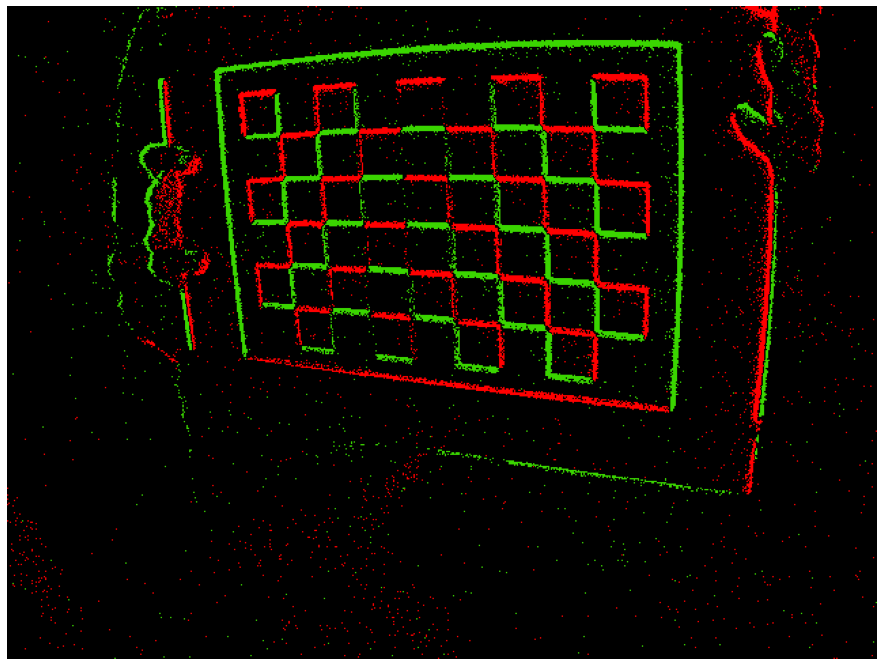

Parser took: 119 seconds.


In [1]:

%matplotlib inline


import sys, getopt
import pdb
import time
import cv2 as cv
import numpy as np
import pdb
import matplotlib.pyplot as plt
from utils import getNextRow, preprocess, print_all
from matplotlib.colors import LinearSegmentedColormap

my_gradient = LinearSegmentedColormap.from_list('my_gradient', (
    # Edit this gradient at https://eltos.github.io/gradient/#FF0001-000000-3BD600
    (0.000, (1.000, 0.000, 0.004)),
    (0.500, (0.000, 0.000, 0.000)),
    (1.000, (0.231, 0.839, 0.000))))

if __name__ == "__main__":

    x_max = 640
    y_max = 480
    scale = 2/80
    fps = 60
    activity = 1
    image_of_interest = 255

    screen = np.zeros((x_max, y_max),dtype=int)
    print(screen.shape)

    inputfile = "recordings/rec_cam3.aedat4"
    nb_events = -1

    start = time.time()

    line_count = 0
    photo_counter = 0
    change_interval = int(1000/fps)*1000 # 33 ms : 30Hz  
    for t, x, y, p in getNextRow(inputfile):    
        

        # Extract time offset
        if line_count == 0 :
            first_t = t
            t_next_change = change_interval

        t_relative = t - first_t # first event occurs at t=0

        # Visualize Stuff and Prepare for next frame
        if t_relative > t_next_change:
    
            inactive_pixels = np.sum(screen == 0)
            if inactive_pixels < int((100-activity)/100*x_max*y_max):
                if photo_counter == image_of_interest-1:
                    screen = preprocess(screen)       
                    plt.figure(figsize=(x_max*scale, y_max*scale))
                    plt.imshow(np.transpose(screen), cmap=my_gradient)  
                    plt.axis('off')
                    plt.show()
                photo_counter += 1
                if photo_counter >= image_of_interest:
                    break

            # Clear window
            screen = np.zeros((x_max, y_max),dtype=int)
            t_next_change += change_interval
            
        else:
            screen[x,y] += 2*p-1


        line_count += 1

        # Check if enough events have been parsed
        if (nb_events > 0) and (line_count > nb_events):
            # Stop parsing since nb_events reached
            print(t_relative)
            print(t_next_change)
            break

    stop = time.time()

    elapsed = stop - start
    print("Parser took: " + str(int(elapsed)) + " seconds.")